## Module 2 - Fine-tuning Mistral-7B-Instruct for sentence classification using QLoRA

This notebook presents an example of how to fine-tune Mistral-7B-Instruct for sentence classification using QLoRA.

Mistral-7B-Instruct is a large language model available in the [HuggingFace model hub](https://huggingface.co/iarfmoose/mistral-7B-instruct). The model is already very good at zero or few-shot sentence classification. However, the goal of this notebook is to teach you how to use QLoRA to fine-tune LLMs.

QLoRA is a fine-tuning approach that reduces memory usage enough to finetune a 65B parameter model on a single 48GB GPU while preserving full 16-bit finetuning task performance. For more details, please refer to the [QLoRA paper](https://arxiv.org/abs/2106.09647).


# Installing required packages

In this example, we have to install the following libraries:  `transformers`, `datasets`, `torch`, `peft`, `bitsandbytes`, and `trl`.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc.

**`datasets`**:

Datasets is another open-source library developed by Hugging Face that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more.


**`torch`**:

PyTorch is an open-source machine learning library that provides a wide range of tools and utilities for building and training custom deep learning models. It is already installed in the Colab environment, but we need to install its latest version.

**`peft`**:

🤗 PEFT, or Parameter-Efficient Fine-Tuning (PEFT), is a library for efficiently adapting pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model’s parameters. We use PEFT in this example because it supports QLoRA.


**`bitsandbytes`**:

BitsAndBytes is a library designed to optimize the training of neural networks on modern GPUs. It offers efficient implementations of 8-bit optimizers, which significantly reduce the memory footprint of model parameters and gradients. This reduction in memory usage enables training larger models or using larger batch sizes within the same memory constraints.


**`trl`**:

🤗 TRL, or Transfer Learning Library, is a library for training and evaluating transfer learning models. It provides a unified API for training and evaluating various transfer learning models.

In [1]:
!pip install -q torch
!pip install -q git+https://github.com/huggingface/transformers #huggingface transformers for downloading models weights
!pip install datasets
!pip install -q peft  # Parameter efficient finetuning - for qLora Finetuning
!pip install -q bitsandbytes  # For Model weights quantization
!pip install -q trl  # Transformer Reinforcement Learning - For Finetuning using Supervised Fine-tuning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 13.2 MB/s eta 0:00:00


# Setting the device

In this example, we will use a GPU to speed up the fine-tuning process. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU.

For using a GPU in Google Colab:
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "A100 GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook.

**IMPORTANT**: This example requires a GPU with at least 40GB of memory. If you are using Google Colab, you can select a GPU with 40GB of memory by following the steps above. If you are using a different environment, please make sure that your GPU has at least 40GB of memory.

In [2]:
!nvidia-smi

Sun Nov 19 18:41:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading Dataset

The SST-2 dataset, or the Stanford Sentiment Treebank, is popular for sentiment analysis tasks in Natural Language Processing (NLP). It consists of movie reviews from the Rotten Tomatoes website that are labeled with either a positive or negative sentiment. The dataset contains 10,662 sentence-level movie reviews, with approximately half of the reviews labeled as positive and the other half labeled as negative. The reviews are also relatively evenly distributed in length, with a median length of 18 tokens.

The SST-2 dataset has become a benchmark dataset for sentiment analysis in NLP, and many researchers use it to evaluate the performance of their models. The dataset's popularity is partly due to its high-quality labels and the task's relative simplicity, making it an accessible starting point for researchers and developers new to NLP.

In this example, we're using the **`datasets`** library to download and load the training and validation sets of the dataset.

In [3]:
from datasets import load_dataset

test_dataset = load_dataset('glue', 'sst2', split='validation')
train_dataset = load_dataset('glue', 'sst2', split='train')

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

# Data Preparation

Now, we will prepare the data for training our model. First, we define a template with the fields `sentence` and `class`. Then, we use the `map` method to apply this template to the dataset. This will create a new dataset with the fields `sentence` and `class` for each example in the original dataset.

In [4]:
template = """<s>[INST] Your task is to classify sentences' sentiment as 'positive' or 'negative'.

Sentence: {sentence} [\INST]
{class}</s>"""

Before, we need to convert the labels from 0 and 1 to "negative" and "positive". We can do this by using the `map` method to apply a function to each example in the dataset. The function will take the label as input and return the corresponding string and store in the column `class`.

In [5]:
POSITIVE_LABEL = "positive"
NEGATIVE_LABEL = "negative"

train_dataset = train_dataset.map(lambda example: {'class': POSITIVE_LABEL if example["label"] == 1 else NEGATIVE_LABEL})
train_dataset = train_dataset.map(lambda example: {"text": template.format(**example)})


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

The code below converts the `label` column of the test dataset into a list of strings with `"positive"` and `"negative"` labels. This is for comparing the model's predictions with the actual labels of the dataset.

In [6]:
test_dataset = test_dataset.map(lambda example: {'class': POSITIVE_LABEL if example["label"] == 1 else NEGATIVE_LABEL})

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

# Fine-tuning

## Setting Model Parameters

We need to set various parameters for our fine-tuning process, including QLoRA (Quantization LoRA) parameters, bitsandbytes parameters, and training arguments:

In [7]:
# The model that you want to train from the Hugging Face hub
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

# Fine-tuned model name
new_model = "mistralai-SST-Instruct"

Setting the QLora Parameters

1. **lora_r (LoRA attention dimension)**:
   - the rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters.

2. **lora_alpha (Alpha parameter for LoRA scaling)**:
   - This parameter is the LoRA scaling factor applied to the modifications.

3. **lora_dropout (Dropout probability for LoRA layers)**:
   - This parameter represents the dropout rate applied to the LoRA layers.

In [8]:
# LoRA attention dimension
lora_r = 64 # @param

# Alpha parameter for LoRA scaling
lora_alpha = 16 # @param

# Dropout probability for LoRA layers
lora_dropout = 0.1 # @param

Bitsandbytes parameters. These parameters focus on the implementation of 4-bit precision in model loading and computation. Here's an explanation of each:

1. **use_4bit (Activate 4-bit precision base model loading)**:
   - This parameter, when set to `True`, indicates that the base model (i.e., the pre-trained model or initial model weights) should be loaded using 4-bit precision.
2. **bnb_4bit_compute_dtype (Compute dtype for 4-bit base models)**:
   - This parameter specifies the data type to be used for computations in the context of 4-bit base models.
   - The value `"float16"` indicates that computations should be done using 16-bit floating-point numbers.

3. **bnb_4bit_quant_type (Quantization type)**:
   - This parameter determines the type of quantization to be used for the 4-bit models.
   - The options `"fp4"` and `"nf4"` refer to different quantization schemes.

4. **use_nested_quant (Activate nested quantization for 4-bit base models)**:
   - When set to `True`, this parameter enables nested quantization for 4-bit base models.
   - Nested quantization, often referred to as double quantization, involves applying a second layer of quantization on top of an already quantized model. This can be used for further reducing the model size or for specialized computational optimizations.

In [9]:
# Activate 4-bit precision base model loading
use_4bit = True # @param

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16" # @param

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4" # @param ["nf4","fp4"]

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False # @param

Now, let's define the training arguments.

1. **output_dir**:
   - Specifies the directory where the model predictions and checkpoints will be stored.

2. **num_train_epochs**:
   - Sets the number of epochs for training, where one epoch means one pass through the entire training dataset. We set it to `1`

3. **fp16, bf16**:
   - Enable training with 16-bit floating-point precision (`fp16`) or 16-bit bfloat precision (`bf16`).

4. **per_device_train_batch_size**:
   - Determines the batch size for training per GPU. This will depend on the GPU used. For an A100, we can use a batch size of 16 examples.

5. **per_device_eval_batch_size**:
   - Sets the batch size for evaluation per GPU.

6. **gradient_accumulation_steps**:
   - Indicates the number of update steps over which to accumulate gradients.

7. **gradient_checkpointing**:
   - When enabled, saves memory by trading compute for memory. Useful for training large models that would otherwise not fit in memory.

8. **max_grad_norm (Maximum gradient norm)**:
   - Specifies the maximum norm of gradients for gradient clipping, a technique to prevent exploding gradients in deep networks.

9. **learning_rate**:
   - Sets the initial learning rate for the AdamW optimizer.

10. **weight_decay**:
    - Specifies the weight decay to apply to all layers except those with bias or LayerNorm weights, as a regularization technique.

11. **optim**:
    - Defines the optimizer to use, here specified as a variant of AdamW optimized for certain hardware configurations.

12. **lr_scheduler_type**:
    - Determines the learning rate schedule to use. "constant" means the learning rate stays the same throughout training.

13. **max_steps**:
    - Overrides `num_train_epochs` by setting the number of training steps. If set to a negative value, it's ignored. We set this to `100` to reduce the training time. That means, that our example training does not use the entire traing set.

14. **warmup_ratio**:
    - Indicates the proportion of total training steps to use for linear warmup of the learning rate.

15. **group_by_length**:
    - When enabled, sequences are grouped by length into batches. This can save memory and speed up training.

16. **save_steps**:
    - Determines how often to save a model checkpoint in terms of training steps.

17. **logging_steps**:
    - Sets the frequency, in terms of training steps, for logging training progress.


In [10]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results" # @param

# Number of training epochs
num_train_epochs = 1 # @param

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False # @param
bf16 = False # @param

# Batch size per GPU for training
per_device_train_batch_size = 8 # @param

# Batch size per GPU for evaluation
per_device_eval_batch_size = 8 # @param

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1 # @param

# Enable gradient checkpointing
gradient_checkpointing = True # @param

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3 # @param

# Initial learning rate (AdamW optimizer)
learning_rate = 5e-4 # @param

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001 # @param

# Optimizer to use
optim = "paged_adamw_32bit" # @param

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant" # @param

# Number of training steps (overrides num_train_epochs)
max_steps = 100 # @param

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03 # @param

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True # @param

# Save checkpoint every X updates steps
save_steps = 25 # @param

# Log every X updates steps
logging_steps = 25 # @param

Now let's defint the SFTTrainer parameters

1. **max_seq_length**:
   - This parameter specifies the maximum sequence length to be used.

2. **packing**:
   - This parameter indicates whether or not to pack multiple short examples into the same input sequence.
   - When set to `True`, this technique can be used to increase computational efficiency, particularly in batch processing.

3. **device_map**:
   - This parameter is a dictionary that maps parts of the model to specific computing devices.
   - The entry `{"": 0}` specifies that the entire model will be loaded onto GPU 0.

In [11]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

### Lets Load the base model
Let's load the Mistral 7B Instruct base model:

In [12]:
import json
import re
from pprint import pprint

import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from trl import SFTTrainer # For supervised finetuning

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


Load the base model with QLoRA configuration

In [13]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Load MistralAI tokenizer


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

## Fine-Tuning with QLoRA and Supervised Fine-Tuning

We're ready to fine-tune our model using QLoRA. For this tutorial, we'll use the `SFTTrainer` from the `trl` library.

In the context of the code below, `target_modules` refers to specific components or layers of a neural network model that will be modified or adapted using LoRA (Low-Rank Adaptation). LoRA is a technique used to adapt pre-trained models with minimal additional parameters, often used in the context of Transformer models. Here's a breakdown of what each module likely represents:

1. **q_proj, k_proj, v_proj, o_proj**:
   - These refer to the projections for query (q), key (k), value (v), and output (o) in the attention mechanism of a Transformer model.

2. **gate_proj**:
   - This refer to a projection layer associated with gating mechanisms in the model, such as those found in Gated Recurrent Units (GRUs) or similar structures.

3. **up_proj, down_proj**:
   - These refer to projection layers used in upsampling or downsampling within the model.

4. **lm_head**:
   - This refers to the language model head of a Transformer, which is the final layer that produces the output (like the next word in a sequence).

In [15]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=base_model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,

)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

## Let's start the training process

In [16]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.696200
50,0.639400
75,1.423400
100,0.669400


## Merge the fine-tuned model

After fine-tuning, we can merge the fine-tuned model with the base model to get a single model that can be used for inference. This is done by using the PEFT. First, let's clean up the GPU memory by deleting the fine-tuned model. You can also restart the runtime to clear the GPU memory.

In [17]:
# Empty VRAM
import gc
del base_model
gc.collect()

del trainer
gc.collect()

0

In [18]:
torch.cuda.empty_cache()

In [19]:
gc.collect()

47500

Now, let's load the base model and fine-tuned model and merge them using PEFT.

In [20]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, new_model,)
merged_model= merged_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's save our merged model

In [21]:
# Save the merged model
merged_model.save_pretrained("merged_model", safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## Test the merged model

The following code performs the inference stage of the evaluation finetuned Mistral-7B-Instruct model. We define a function called **`classify_sentence`** that is designed to use a pretrained model, likely a variant of a large language model similar to GPT, for sentiment analysis. The description below outlines the steps taken in the function to classify the sentiment of a given sentence as either positive, negative, or possibly neutral. I'll expand on the description by going through the function step-by-step:

1. The function accepts a single parameter, `sentence`, which is the text input whose sentiment is to be classified.

2. The `sentence` is formatted with the predefined prompt template. This prompt engineering is a common practice when using language models for specific tasks, as it provides context to the model about the task it is supposed to perform.

3. The `tokenizer` is applied to the formatted text. Tokenizers convert text into a format that models can understand, which in this case is a series of tokens. The tokenizer is configured to:
   - Return tensors compatible with PyTorch (`return_tensors="pt"`).
   - Not add special tokens that are usually used to indicate the start and end of a sequence (`add_special_tokens=False`).

4. The tokenized input (`encodeds`) is then converted to a PyTorch tensor and moved to the appropriate device (GPU) for inference.

5. The inference is performed inside a `torch.no_grad()` context manager, which disables gradient calculations. This is used because we are making predictions, not training the model, and therefore do not need gradients, which would only use extra memory and computational power.

6. The `model.generate` function is called to generate a response. This function takes several parameters, such as:
   - `**model_inputs`: The tokenized inputs prepared earlier.
   - `max_length=8000`: This sets the maximum length of the model's output. The choice of 8000 seems unusually high for sentence classification and might be tailored to specific requirements of the task or the model's capacity.
   - `bos_token_id=model.config.bos_token_id`: This specifies the beginning-of-sentence token id, signaling the model where a new sentence starts.
   - `eos_token_id=model.config.eos_token_id`: This specifies the end-of-sentence token id, signaling the model where a sentence ends.
   - `pad_token_id=model.config.eos_token_id`: This is used for padding shorter sentences to a uniform length. It's unusual to see the end-of-sentence token used for padding, which could be a specific requirement of this model or a mistake.

7. After the model generates a response, `torch.cuda.empty_cache()` is called to free up unused memory on the GPU. This is helpful in managing GPU resources, especially when processing multiple requests or dealing with large models.

8. Finally, the `tokenizer.decode` function is used to convert the model's output tokens back into human-readable text. The `skip_special_tokens=True` argument removes any special tokens (like padding or end-of-sentence tokens) from the output. The function also skips the input tokens (`outputs[0][len(model_inputs["input_ids"][0]):]`) to only return the newly generated text.


In [22]:
device = "cuda:0"
prompt = """<s>[INST]You are a sentiment classifier. Use only "positive" or "negative".

Sentence: {sentence}[\INST]
"""
def classify_sentence(sentence):
  text = prompt.format(sentence=sentence)
  encodeds = tokenizer(text, return_tensors="pt", add_special_tokens=False)
  model_inputs = encodeds.to(device)

  with torch.no_grad():
    outputs = merged_model.generate(**model_inputs,max_length=15,bos_token_id=merged_model.config.bos_token_id,
                                eos_token_id=merged_model.config.eos_token_id,
                                pad_token_id=merged_model.config.eos_token_id
                             )
    torch.cuda.empty_cache()

  return tokenizer.decode(outputs[0][len(model_inputs["input_ids"][0]):], skip_special_tokens=True)

classify_sentence("This movie is too bad")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1362: UserWarning: Input length of input_ids is 35, but `max_length` is set to 15. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


'negative'

The code below uses the **`classify_sentence`** function to make predictions on the test dataset. We loop through the test dataset and apply the **`classify_sentence`** function to each example. The predictions are stored in a list called **`predictions`**.

In [23]:
from tqdm import tqdm
predictions = []
references = test_dataset["class"]
for item in tqdm(test_dataset):
  predicted = classify_sentence(item['sentence'])
  predictions.append(predicted)


  0%|          | 0/872 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1362: UserWarning: Input length of input_ids is 40, but `max_length` is set to 15. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1362: UserWarning: Input length of input_ids is 38, but `max_length` is set to 15. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
  0%|          | 2/872 [00:00<00:44, 19.34it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1362: UserWarning: Input length of input_ids is 55, but `max_length` is set to 15. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1362: UserWarning: Input length of input_ids is 59, but `max_

In [24]:
from collections import Counter

Counter(predictions).most_common()

[('negative', 444), ('pos', 428)]

In [25]:
predictions = ["positive" if p == "pos" else p for p in predictions]

# Evaluation Metric

To compute accuracy, we need to define a custom **`string_accuracy`** function since model outputs text rather than numerical values. Therefore, we cannot use the built-in accuracy function directly, which expects numerical values as inputs.

The following code defines the **`string_accuracy`** function. It takes two lists of strings as inputs, **`predictions`** and **`references`**. The function computes accuracy by counting the number of predictions that match the corresponding reference and dividing by the total number of predictions.

In [26]:
def string_accuracy(predictions, references):
    correct = sum([1 for p, r in zip(predictions, references) if p.lower() == r.lower()])
    total = len(predictions)
    return correct / total

In [27]:
accuracy = string_accuracy(predictions=predictions, references=references)
accuracy

0.9288990825688074

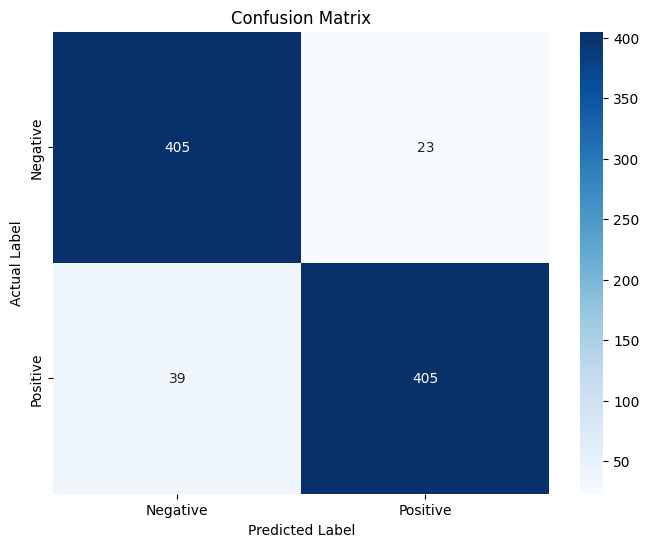

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Convert labels to a numerical form
labels = {"positive": 1, "negative": 0}
y_true_num = [labels[label] for label in references]
y_pred_num = [labels[label] for label in predictions]

# Compute the confusion matrix
cm = confusion_matrix(y_true_num, y_pred_num)

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

# Labels, title, and ticks
ax.set_ylabel('Actual Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()
